In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Data Augmentation With ImageDataGenerator,Feature Extraction Using HOG and Model Fitting Using SVM and RandomForest
import time
st_time = time.time()
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from skimage.feature import hog
import skimage.exposure as exposure
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(f"Imports complete in {time.time()-st_time:.2f} seconds")

Imports complete in 14.32 seconds


In [3]:
def load_parkinson_dataset(dataset_path, image_size=(100, 100)):
    train_images = []
    test_images = []
    train_labels = []
    test_labels = []
    # Iterate through 'spiral' and 'wave' folders
    for category in ['spiral', 'wave']:
        category_path = os.path.join(dataset_path, category)

        # Iterate through 'training' and 'testing' folders
        for split in ['training', 'testing']:
            split_path = os.path.join(category_path, split)

            # Iterate through 'healthy' and 'parkinson' subfolders
            for label in ['healthy', 'parkinson']:
                label_path = os.path.join(split_path, label)

                # Load and resize images from each subfolder
                for file in os.listdir(label_path):
                    file_path = os.path.join(label_path, file)
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, image_size)  # Resize to a fixed size

                    if split == 'training':
                        if category == 'spiral' or category == 'wave':
                            train_images.append(image)
                            train_labels.append([1 if label == 'parkinson' else 0])
                        else:
                            continue
                    elif split == 'testing':
                        if category == 'spiral' or category == 'wave':
                            test_images.append(image)
                            test_labels.append([1 if label == 'parkinson' else 0])
                        else:
                            continue

    # Convert lists to numpy arrays
    #train_images = np.array(train_images)
    #test_images = np.array(test_images)
    #train_labels = np.array(train_labels)
    #test_labels = np.array(test_labels)

    return (
        train_images,
        test_images,
        train_labels,
        test_labels
    )

dataset_path = r"C:\Users\bharath\Downloads\major_project\drawings"

data_load_st_time = time.perf_counter()
train_images, test_images, train_labels, test_labels = load_parkinson_dataset(dataset_path)
print(f"Dataset loaded in {time.perf_counter()-data_load_st_time:.2f} seconds")

Dataset loaded in 2.34 seconds


In [20]:
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

In [21]:
augmented_images = []
augmented_labels = []

# Iterate over the input images and apply data augmentation
for img, label in zip(train_images, train_labels):
    # Reshape image for datagen.flow method
    img = img.reshape((1, 100, 100, 1))  # Add channel dimension

    # Generate augmented images
    augmented_iter = datagen.flow(img, batch_size=1)
    for batch in augmented_iter:  # Iterate directly over the iterator
        augmented_img = batch[0].astype(np.uint8)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)  # Append the corresponding label
        
        # Break the loop after generating desired number of augmented images per original image
        if len(augmented_images) % 5 == 0:
            break

# Add the augmented images to the input images list
train_images_extended = train_images + augmented_images
train_labels_extended = train_labels + augmented_labels

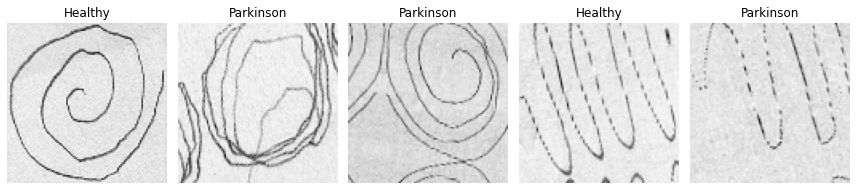

In [22]:
import random
import matplotlib.pyplot as plt

# Select 5 random indices from train_images_extended
random_indices = random.sample(range(len(train_images_extended)), 5)

# Define labels mapping
label_mapping = {0: 'Healthy', 1: 'Parkinson'}

# Plot the random images with labels
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    image = train_images_extended[idx]
    label_list = train_labels_extended[idx]  # Get label list
    label = label_list[0]  # Extract the label value from the list
    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap='gray')  # Assuming the images are grayscale
    plt.axis('off')
    plt.title(label_mapping[label])  # Set title based on label
plt.tight_layout()
plt.show()

In [71]:
def extract_hog_features(image):
    # Calculate HOG features
    features, hog_image = hog(image, orientations=8, pixels_per_cell=(5,5),
                              cells_per_block=(5, 5), visualize=True)
    
    # Enhance the contrast of the HOG image for visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return features, hog_image_rescaled

In [72]:
def preprocess_image(image, target_size=(100, 100)):
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5,5), 0)
    
    # Apply unsharp mask
    unsharp_image = unsharp_mask(image)
    
    # Resize the image
    resized_image = cv2.resize(unsharp_image, target_size)

    return resized_image

def unsharp_mask(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 0.5 + strength, blurred, -strength, 0)
    return sharpened

In [73]:
train_hog_features=[]
train_hog_images=[]
for img in tqdm(train_images_extended):
    preprocessed_image=preprocess_image(img)
    features,images=extract_hog_features(preprocessed_image)
    train_hog_features.append(features)
    train_hog_images.append(images)

100%|████████████████████████████████████████████████████████████████████████████████| 864/864 [01:11<00:00, 12.13it/s]


In [74]:
test_hog_features=[]
test_hog_images=[]
for img in tqdm(test_images):
    preprocessed_image=preprocess_image(img)
    features,images=extract_hog_features(preprocessed_image)
    test_hog_features.append(features)
    test_hog_images.append(images)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.54it/s]


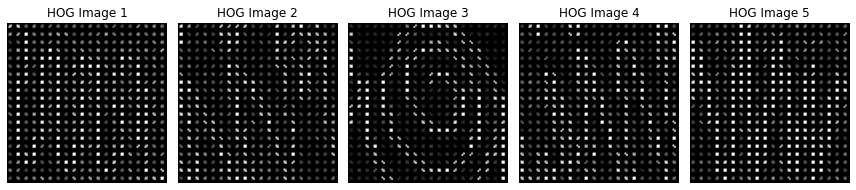

In [75]:
import random
import matplotlib.pyplot as plt

# Select 5 random indices from train_hog_images
random_indices = random.sample(range(len(train_hog_images)), 5)

# Plot the random HOG images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    hog_image = train_hog_images[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(hog_image, cmap='gray')  # Assuming the HOG images are grayscale
    plt.axis('off')
    plt.title(f'HOG Image {i + 1}')
plt.tight_layout()
plt.show()

            Model  Accuracy  Precision    Recall  F1 Score
0      SVM Linear  0.733333   0.705882  0.800000  0.750000
1  SVM Polynomial  0.833333   0.884615  0.766667  0.821429
2         SVM RBF  0.800000   0.821429  0.766667  0.793103
3    RandomForest  0.650000   0.655172  0.633333  0.644068


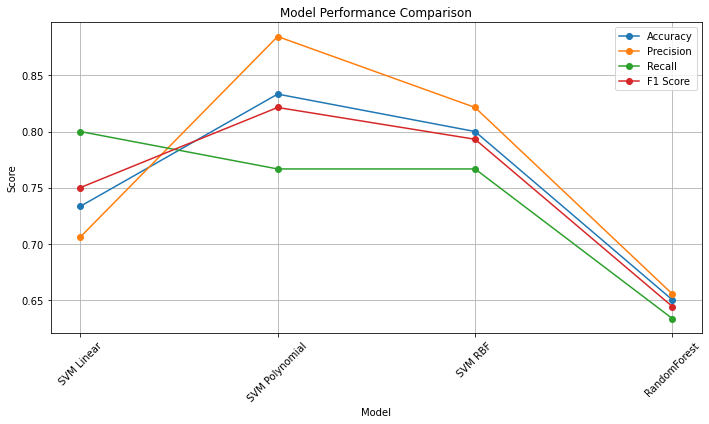

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already defined and split your data into x_train, y_train, x_test, y_test
# Convert lists to NumPy arrays
X_train = np.array(train_hog_features)  # Assuming train_hog_features is a list of feature vectors
X_test = np.array(test_hog_features)  # Assuming test_hog_features is a list of feature vectors
y_train = np.array(train_labels_extended)  # Assuming train_labels_extended is a list of labels
y_test = np.array(test_labels)  # Assuming test_labels is a list of labels

# Define the models
models = {
    'SVM Linear': SVC(kernel='linear'),
    'SVM Polynomial': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1])

# Create a pandas DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the comparison table
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

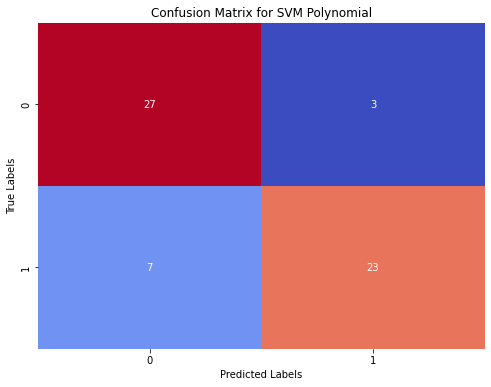

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Find the model with the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

# Get predictions for the best model
y_pred_best_model = models[best_model].predict(X_test)

# Compute confusion matrix for the best model
cm_best_model = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [79]:
#Feature Extraction Using Pretrained Densenet and Model Fitting using SVM and RandomForest
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
# Load DenseNet model
densenet_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(100,100,3))
densenet_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 106, 106, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 50, 50, 64)        │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 50, 50, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 50, 50, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 52, 52, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 25, 25, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 25, 25, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 25, 25, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 25, 25, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 25, 25, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 25, 25, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 25, 25, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 25, 25, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [80]:
train_features_densenet = []
test_features_densenet = []

for category in ['spiral', 'wave']:
    category_path = os.path.join(dataset_path, category)

    for split in ['training', 'testing']:
        split_path = os.path.join(category_path, split)

        for label in ['healthy', 'parkinson']:
            label_path = os.path.join(split_path, label)

            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = load_img(file_path, target_size=(100, 100))
                img = img_to_array(img)
                img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
                img = tf.keras.applications.densenet.preprocess_input(img)
                feature = densenet_model.predict(img, verbose=0)
                if split == 'training':
                    train_features_densenet.append(feature.flatten())
                else:
                    test_features_densenet.append(feature.flatten())

train_features_densenet = np.array(train_features_densenet)
test_features_densenet = np.array(test_features_densenet)

            Model  Accuracy  Precision    Recall  F1 Score
0      SVM Linear  0.783333   0.717949  0.933333  0.811594
1  SVM Polynomial  0.833333   0.833333  0.833333  0.833333
2         SVM RBF  0.816667   0.880000  0.733333  0.800000
3    RandomForest  0.850000   0.920000  0.766667  0.836364


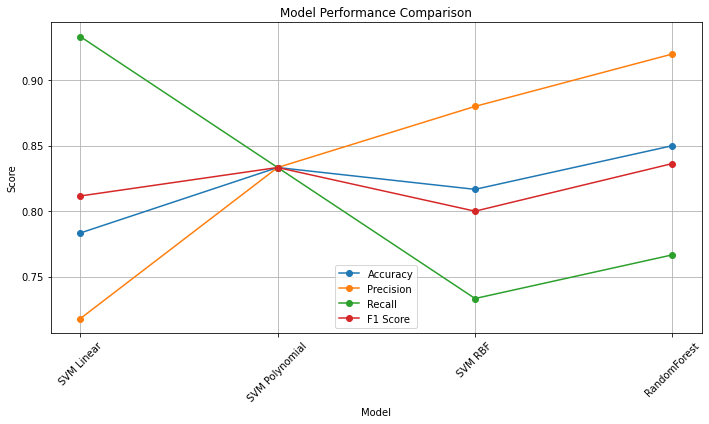

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already defined and split your data into x_train, y_train, x_test, y_test
# Convert lists to NumPy arrays
X_train = np.array(train_features_densenet)  # Assuming train_hog_features is a list of feature vectors
X_test = np.array(test_features_densenet)  # Assuming test_hog_features is a list of feature vectors
y_train = np.array(train_labels)  # Assuming train_labels_extended is a list of labels
y_test = np.array(test_labels)  # Assuming test_labels is a list of labels

# Define the models
models = {
    'SVM Linear': SVC(kernel='linear'),
    'SVM Polynomial': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1])

# Create a pandas DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the comparison table
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

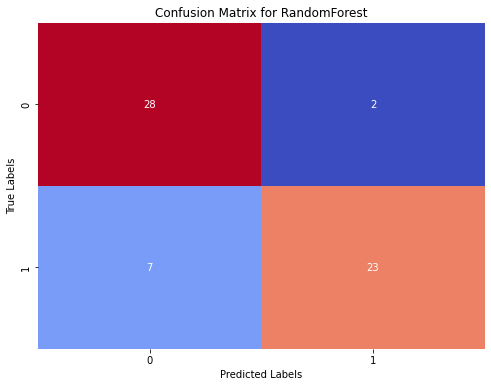

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Find the model with the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

# Get predictions for the best model
y_pred_best_model = models[best_model].predict(X_test)

# Compute confusion matrix for the best model
cm_best_model = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [83]:
#Feature Extraction Using Pretrained VGG16 and Model Fitting Using SVM and RandomForest
from tensorflow.keras.applications import VGG16
# Load pre-trained VGGNet without classification layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
train_features_vgg = []
test_features_vgg = []

for category in ['spiral', 'wave']:
    category_path = os.path.join(dataset_path, category)

    for split in ['training', 'testing']:
        split_path = os.path.join(category_path, split)

        for label in ['healthy', 'parkinson']:
            label_path = os.path.join(split_path, label)

            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = load_img(file_path, target_size=(100, 100))
                img = img_to_array(img)
                img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
                img = tf.keras.applications.vgg16.preprocess_input(img)
                feature = vgg_model.predict(img, verbose=0)
                if split == 'training':
                    train_features_vgg.append(feature.flatten())
                else:
                    test_features_vgg.append(feature.flatten())

train_features_vgg = np.array(train_features_vgg)
test_features_vgg = np.array(test_features_vgg)

            Model  Accuracy  Precision    Recall  F1 Score
0      SVM Linear  0.883333   0.828571  0.966667  0.892308
1  SVM Polynomial  0.816667   0.787879  0.866667  0.825397
2         SVM RBF  0.816667   0.851852  0.766667  0.807018
3    RandomForest  0.850000   0.862069  0.833333  0.847458


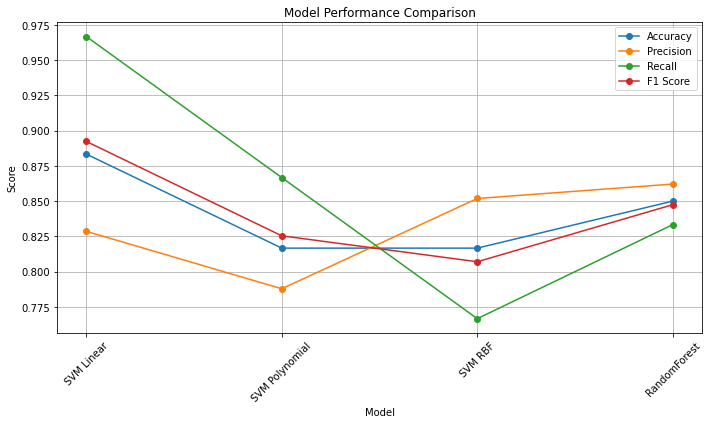

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already defined and split your data into x_train, y_train, x_test, y_test
# Convert lists to NumPy arrays
X_train = np.array(train_features_vgg)  # Assuming train_hog_features is a list of feature vectors
X_test = np.array(test_features_vgg)  # Assuming test_hog_features is a list of feature vectors
y_train = np.array(train_labels)  # Assuming train_labels_extended is a list of labels
y_test = np.array(test_labels)  # Assuming test_labels is a list of labels

# Define the models
models = {
    'SVM Linear': SVC(kernel='linear'),
    'SVM Polynomial': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1])

# Create a pandas DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the comparison table
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

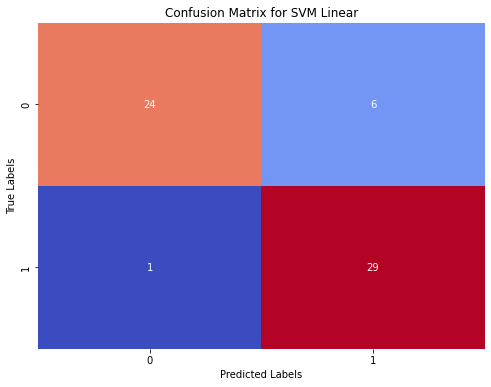

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Find the model with the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

# Get predictions for the best model
y_pred_best_model = models[best_model].predict(X_test)

# Compute confusion matrix for the best model
cm_best_model = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [87]:
#Feature Extraction Using Pretrained Resnet50 and Model Fitting Using SVM and RandomForest
from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet50 without classification layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 106, 106, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 50, 50, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 50, 50, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 50, 50, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 52, 52, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 25, 25, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 25, 25, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 25, 25, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 25, 25, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 25, 25, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 25, 25, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 25, 25, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 25, 25, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 25, 25, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [88]:
train_features_resnet = []
test_features_resnet = []

for category in ['spiral', 'wave']:
    category_path = os.path.join(dataset_path, category)

    for split in ['training', 'testing']:
        split_path = os.path.join(category_path, split)

        for label in ['healthy', 'parkinson']:
            label_path = os.path.join(split_path, label)

            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = load_img(file_path, target_size=(100, 100))
                img = img_to_array(img)
                img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
                img = tf.keras.applications.resnet50.preprocess_input(img)
                feature = resnet_model.predict(img, verbose=0)
                if split == 'training':
                    train_features_resnet.append(feature.flatten())
                else:
                    test_features_resnet.append(feature.flatten())

train_features_resnet = np.array(train_features_resnet)
test_features_resnet = np.array(test_features_resnet)

            Model  Accuracy  Precision    Recall  F1 Score
0      SVM Linear  0.816667   0.806452  0.833333  0.819672
1  SVM Polynomial  0.816667   0.806452  0.833333  0.819672
2         SVM RBF  0.783333   0.774194  0.800000  0.786885
3    RandomForest  0.750000   0.727273  0.800000  0.761905


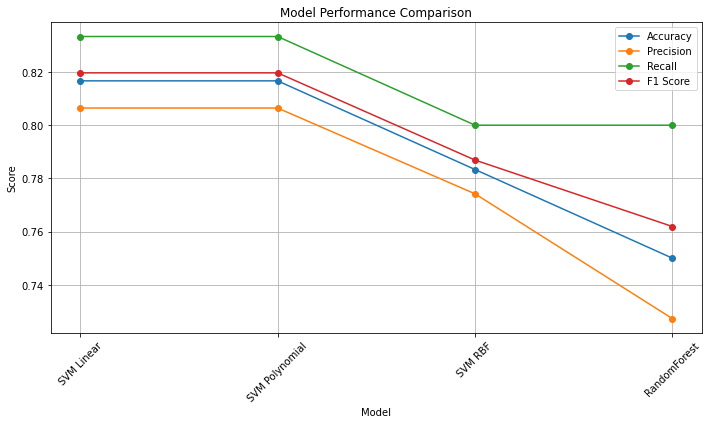

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already defined and split your data into x_train, y_train, x_test, y_test
# Convert lists to NumPy arrays
X_train = np.array(train_features_resnet)  # Assuming train_hog_features is a list of feature vectors
X_test = np.array(test_features_resnet)  # Assuming test_hog_features is a list of feature vectors
y_train = np.array(train_labels)  # Assuming train_labels_extended is a list of labels
y_test = np.array(test_labels)  # Assuming test_labels is a list of labels

# Define the models
models = {
    'SVM Linear': SVC(kernel='linear'),
    'SVM Polynomial': SVC(kernel='poly'),
    'SVM RBF': SVC(kernel='rbf'),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1])

# Create a pandas DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the comparison table
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

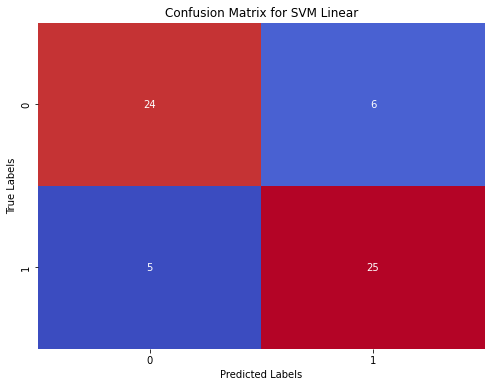

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Find the model with the highest accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

# Get predictions for the best model
y_pred_best_model = models[best_model].predict(X_test)

# Compute confusion matrix for the best model
cm_best_model = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()